In [ ]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# --- Sklearn Imports (for Preprocessing, Splitting, and Metrics) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Matplotlib Setup ---
%matplotlib inline
sns.set(style="whitegrid", palette="pastel")

print("All libraries imported successfully.")

All libraries imported successfully.


In [1]:
CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes'
# ---------------------

if not os.path.isdir(CLASSIFIER_DIR):
    print(f"Error: Classifier directory '{CLASSIFIER_DIR}' not found.")
    print("Please update the path in this cell.")
else:
    # Add the folder to the system path to allow imports
    if CLASSIFIER_DIR not in sys.path:
        sys.path.append(os.path.abspath(CLASSIFIER_DIR))
    
    try:
        # Import all 9 of your classifier classes
        from KNN import KNN
        from LogisticRegression import LogisticRegression
        from DecisionTree import DecisionTreeClassifier # Assumes Node class is in this file
        from RandomForest import RandomForestClassifier # Assumes this imports DecisionTree
        from SVM import LinearSVM
        from GaussianNaiveBayes import GaussianNaiveBayes
        from MultiLayerPerceptron import SimpleMLP
        from LinearDiscriminantAnalysis import LDA
        from AdaBoost import AdaBoost # Assumes DecisionStump is in this file
        
        print("✅ Successfully imported all 9 from-scratch classifiers.")
    except ImportError as e:
        print(f"--- 🛑 IMPORT ERROR ---")
        print(f"Error importing classifiers: {e}")
        print("Please check file/class names in your 'Classifier_codes' folder.")
    except Exception as e:
        print(f"An unexpected error occurred during import: {e}")

✅ Successfully imported all 9 from-scratch classifiers.


In [2]:
# This helper class allows your binary-only models (LogReg, SVM, MLP, AdaBoost)
# to work for multi-class problems (if the dataset were multi-class).
# For this binary dataset, it will just train a single model.

class OvRWrapper:
    """Wraps a binary classifier to support multi-class OvR classification."""
    def __init__(self, binary_classifier_class, **kwargs):
        self.binary_classifier_class = binary_classifier_class
        self.kwargs = kwargs
        self.models = {}
        self.classes_ = None
        self.binary_le = None # For handling the binary-only case

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        if n_classes <= 2:
            # Standard binary problem
            self.binary_le = LabelEncoder() # Use 0/1
            y_binary = self.binary_le.fit_transform(y)
            model = self.binary_classifier_class(**self.kwargs)
            model.fit(X, y_binary)
            # Store model keyed by the original "positive" class label (e.g., 1)
            self.models[self.binary_le.classes_[1]] = model 
        else:
            # Multi-class OvR problem
            for cls in self.classes_:
                y_train_binary = np.where(y == cls, 1, 0)
                model = self.binary_classifier_class(**self.kwargs)
                model.fit(X, y_train_binary)
                self.models[cls] = model
    
    def predict(self, X):
        if len(self.models) == 1 and self.binary_le:
             # Binary case
             model_key = list(self.models.keys())[0]
             binary_preds = self.models[model_key].predict(X)
             # Map 0/1 predictions back to original labels
             return self.binary_le.inverse_transform(binary_preds)
        else:
            # Multi-class OvR case
            all_scores = []
            for cls in self.classes_:
                model = self.models[cls]
                if hasattr(model, 'predict_proba'): # For LogReg, MLP
                    probas = model.predict_proba(X)
                    all_scores.append(probas[:, 1] if probas.ndim == 2 and probas.shape[1] == 2 else probas)
                elif hasattr(model, 'decision_function'): # For SVM
                    all_scores.append(model.decision_function(X))
                else: # Fallback for AdaBoost
                    all_scores.append(model.predict(X))
            
            scores_matrix = np.stack(all_scores, axis=1)
            best_class_indices = np.argmax(scores_matrix, axis=1)
            return self.classes_[best_class_indices]

print("OvRWrapper class defined.")

OvRWrapper class defined.


In [3]:
DATA_PATH = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Diabetes\Diabetes.csv'

if not os.path.exists(DATA_PATH):
    print(f"Error: Data file not found at {DATA_PATH}")
    print("Please update the 'DATA_PATH' variable in this cell.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully. Shape: {df.shape}")

Dataset loaded successfully. Shape: (250000, 18)


In [4]:
print("--- Data Info ---")
df.info()
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes_012          250000 non-null  int64
 1   HighBP                250000 non-null  int64
 2   HighChol              250000 non-null  int64
 3   CholCheck             250000 non-null  int64
 4   BMI                   250000 non-null  int64
 5   Smoker                250000 non-null  int64
 6   Stroke                250000 non-null  int64
 7   HeartDiseaseorAttack  250000 non-null  int64
 8   PhysActivity          250000 non-null  int64
 9   HvyAlcoholConsump     250000 non-null  int64
 10  AnyHealthcare         250000 non-null  int64
 11  NoDocbcCost           250000 non-null  int64
 12  GenHlth               250000 non-null  int64
 13  MentHlth              250000 non-null  int64
 14  Sex                   250000 non-null  int64
 15  Age             

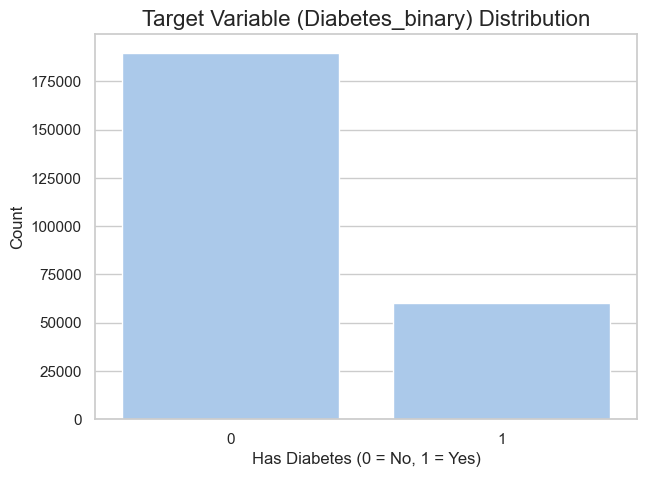

In [5]:
# --- Target Variable: Diabetes_binary ---
plt.figure(figsize=(7, 5))
sns.countplot(x='Diabetes_binary', data=df)
plt.title('Target Variable (Diabetes_binary) Distribution', fontsize=16)
plt.xlabel('Has Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

--- Crosstab: Leaky Feature vs. Target ---
Diabetes_binary       0      1
Diabetes_012                  
0                160446  50564
1                  3400   1098
2                 26100   8392


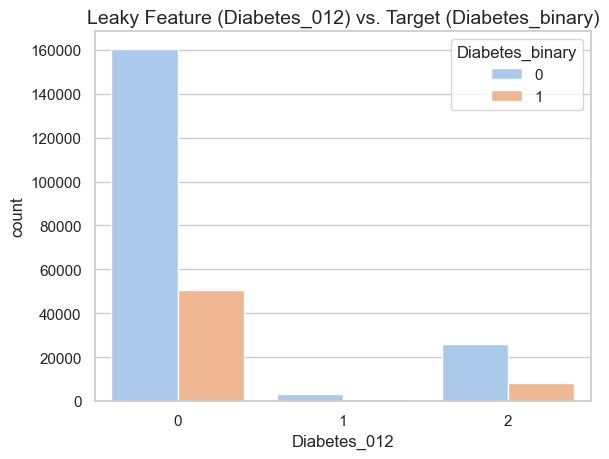

In [6]:
# --- Leaky Feature: Diabetes_012 vs Diabetes_binary ---
# This feature indicates No Diabetes (0), Pre-diabetes (1), or Diabetes (2)
# It's a "leaky" feature because it contains the answer.
print("--- Crosstab: Leaky Feature vs. Target ---")
crosstab = pd.crosstab(df['Diabetes_012'], df['Diabetes_binary'])
print(crosstab)

sns.countplot(x='Diabetes_012', hue='Diabetes_binary', data=df)
plt.title('Leaky Feature (Diabetes_012) vs. Target (Diabetes_binary)', fontsize=14)
plt.show()

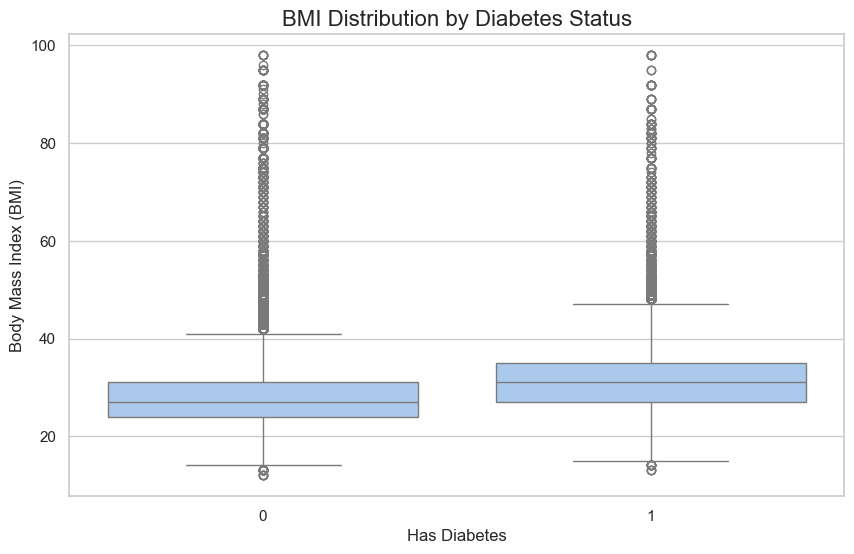

In [7]:
# --- Continuous vs. Target: BMI ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='Diabetes_binary', y='BMI', data=df)
plt.title('BMI Distribution by Diabetes Status', fontsize=16)
plt.xlabel('Has Diabetes')
plt.ylabel('Body Mass Index (BMI)')
plt.show()

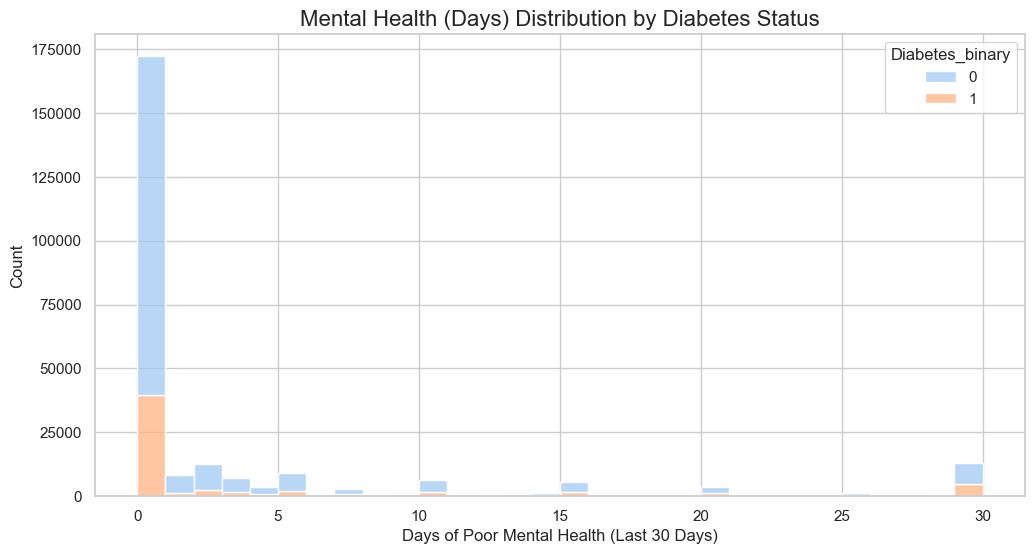

In [8]:
# --- Continuous vs. Target: MentHlth ---
# We'll plot this as a histogram since it's 0-30 days
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='MentHlth', hue='Diabetes_binary', multiple="stack", bins=30)
plt.title('Mental Health (Days) Distribution by Diabetes Status', fontsize=16)
plt.xlabel('Days of Poor Mental Health (Last 30 Days)')
plt.show()

<Figure size 1000x600 with 0 Axes>

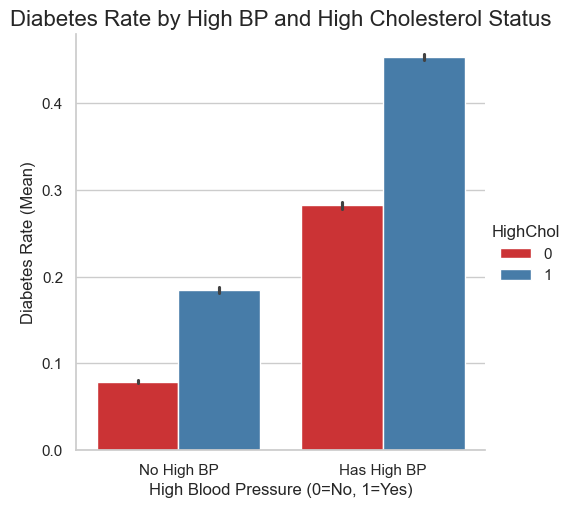

In [9]:
plt.figure(figsize=(10, 6))
sns.catplot(
    data=df, 
    x='HighBP', 
    y='Diabetes_binary', 
    hue='HighChol', 
    kind='bar',
    palette='Set1'
)
plt.title('Diabetes Rate by High BP and High Cholesterol Status', fontsize=16)
plt.xlabel('High Blood Pressure (0=No, 1=Yes)')
plt.ylabel('Diabetes Rate (Mean)')
# Rename x-ticks for clarity
plt.xticks(ticks=[0, 1], labels=['No High BP', 'Has High BP'])
plt.show()

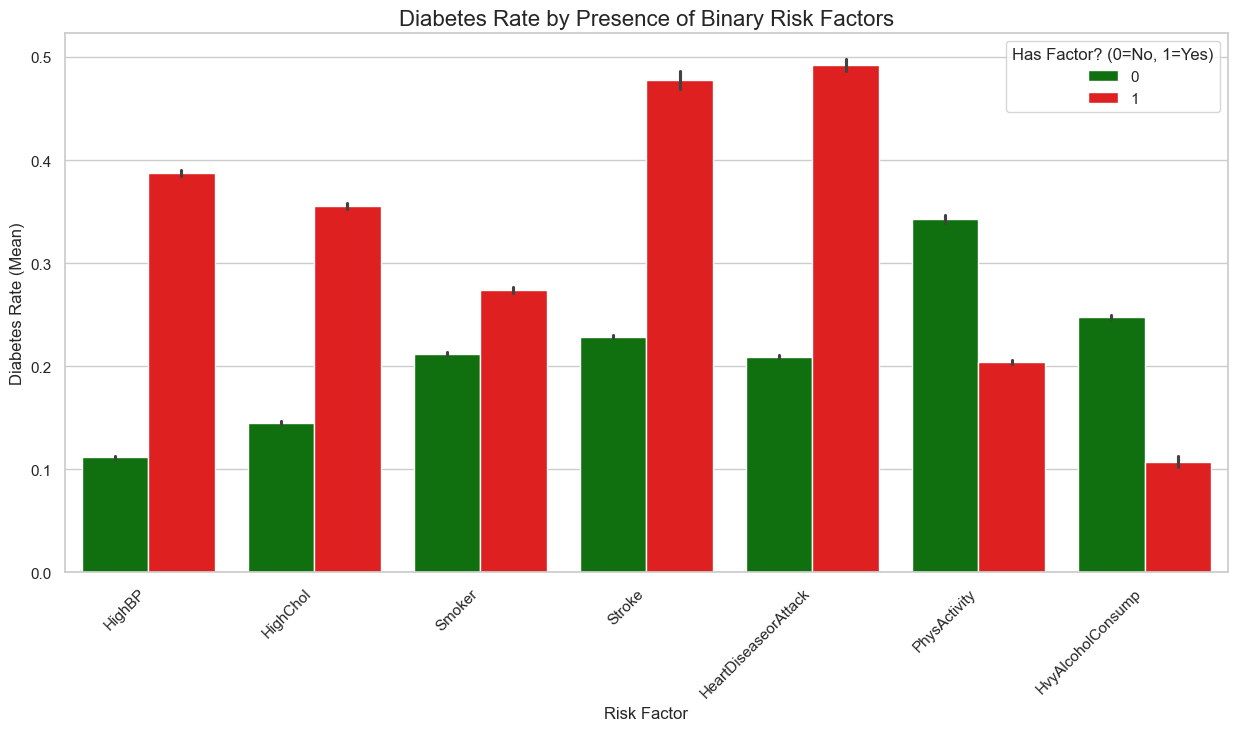

In [10]:
binary_features = [
    'HighBP', 'HighChol', 'Smoker', 'Stroke', 
    'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump'
]

# Melt the DataFrame
df_melted = df.melt(id_vars=['Diabetes_binary'], value_vars=binary_features, 
                    var_name='Risk Factor', value_name='Has_Factor')

# Plot the diabetes rate (mean) for each factor
plt.figure(figsize=(15, 7))
sns.barplot(
    data=df_melted, 
    x='Risk Factor', 
    y='Diabetes_binary', 
    hue='Has_Factor', 
    palette={0: "green", 1: "red"}
)
plt.title('Diabetes Rate by Presence of Binary Risk Factors', fontsize=16)
plt.ylabel('Diabetes Rate (Mean)')
plt.xlabel('Risk Factor')
plt.legend(title='Has Factor? (0=No, 1=Yes)')
plt.xticks(rotation=45, ha='right')
plt.show()

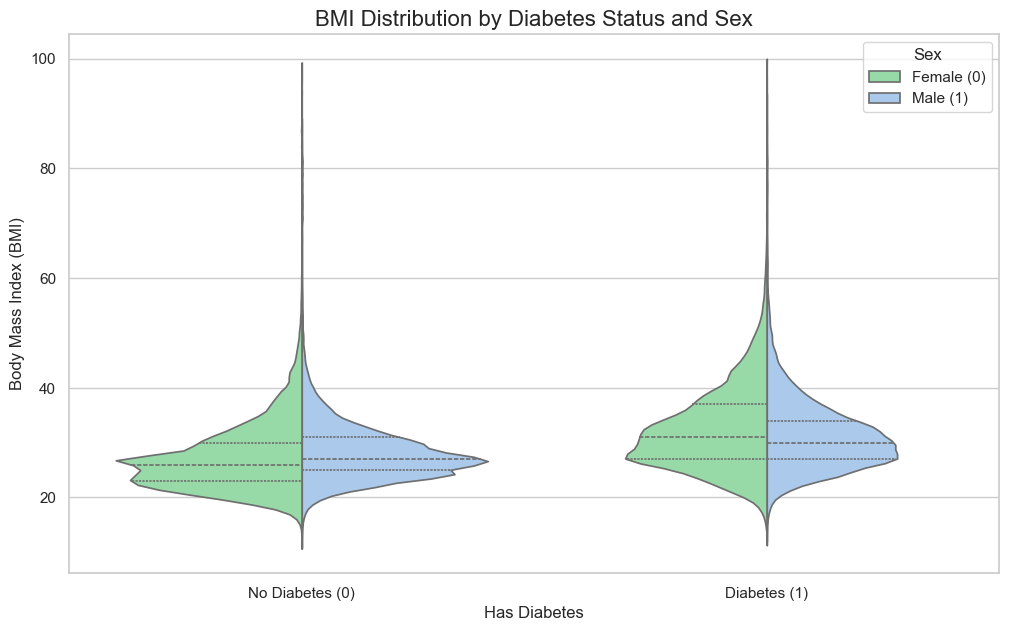

In [11]:
plt.figure(figsize=(12, 7))
sns.violinplot(
    data=df, 
    x='Diabetes_binary', 
    y='BMI', 
    hue='Sex', 
    split=True, # Split violin for Sex
    inner='quartile', # Show quartiles inside
    palette={0: "g", 1: "b"}
)
plt.title('BMI Distribution by Diabetes Status and Sex', fontsize=16)
plt.xlabel('Has Diabetes')
plt.ylabel('Body Mass Index (BMI)')
# Rename x-ticks and hue labels for clarity
plt.xticks(ticks=[0, 1], labels=['No Diabetes (0)', 'Diabetes (1)'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Female (0)', 'Male (1)'], title='Sex')
plt.show()

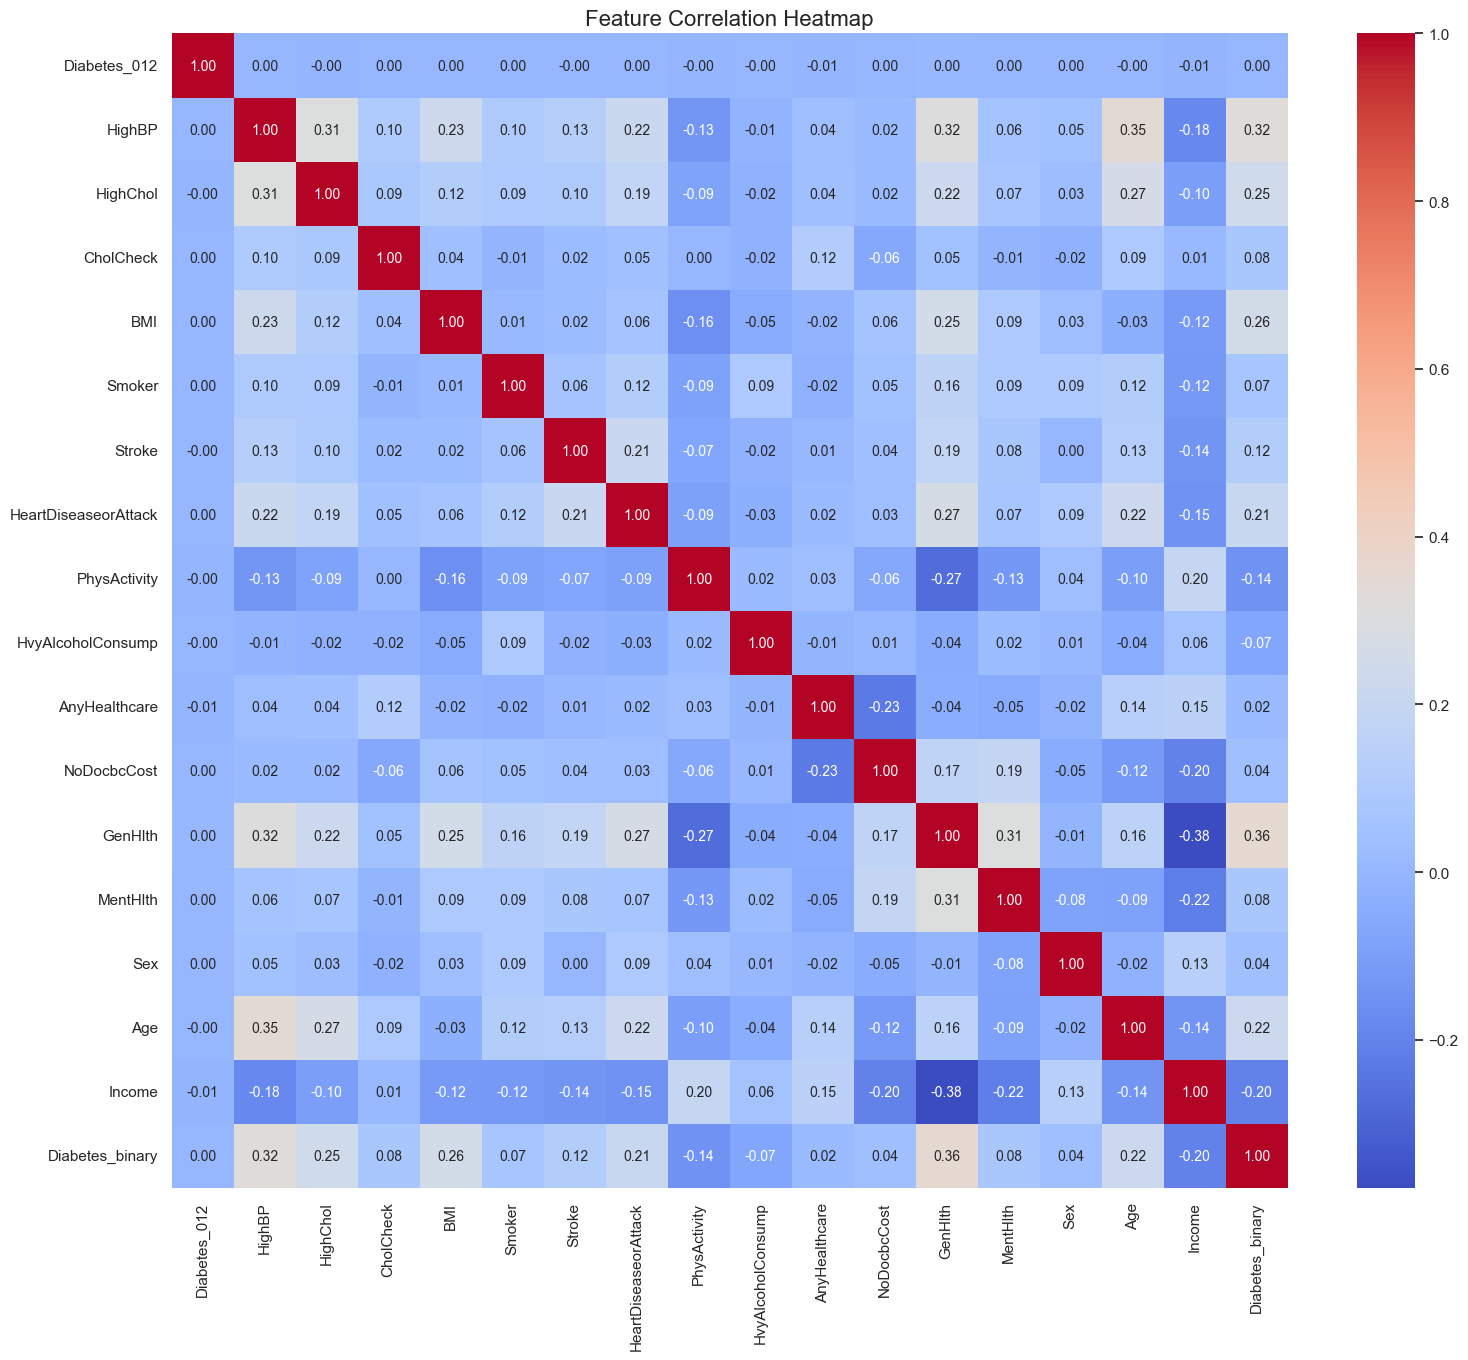

In [12]:
# --- Correlation Heatmap ---
plt.figure(figsize=(18, 15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

In [13]:
x = df.drop("Diabetes_binary", axis=1)
y = df["Diabetes_binary"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (200000, 17)
X_test shape: (50000, 17)
y_train shape: (200000,)
y_test shape: (50000,)


In [14]:
# --- Define Feature Types ---
# Based on the data dictionary, we must manually define which columns are which.

# Truly continuous features
CONTINUOUS_FEATURES = ['BMI', 'MentHlth']

# Categorical features that are numerically encoded
CATEGORICAL_FEATURES = ['GenHlth', 'Age', 'Income']

# Binary features that are already 0/1 (except 'Sex', which we'll include here)
# These only need imputation (if missing) and can be passed through
BINARY_FEATURES = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
    'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump', 
    'AnyHealthcare', 'NoDocbcCost', 'Sex'
]

print(f"Total features defined: {len(CONTINUOUS_FEATURES) + len(CATEGORICAL_FEATURES) + len(BINARY_FEATURES)}")
print(f"Original feature count: {X_train.shape[1]}")


# --- Create Preprocessing Pipelines ---

# Pipeline for continuous data: Impute (mean) -> Scale (StandardScaler)
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical data: Impute (most frequent) -> One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipeline for binary data: Impute (most frequent) -> Pass through
# (We impute just in case, though we know there are no nulls)
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# --- Create the Full ColumnTransformer ---
# This applies the correct pipeline to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, CONTINUOUS_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES),
        ('bin', binary_transformer, BINARY_FEATURES)
    ],
    remainder='passthrough' # Pass through any columns not listed (should be none)
)

print("Preprocessing pipeline defined.")

Total features defined: 16
Original feature count: 17
Preprocessing pipeline defined.


In [15]:

# Fit on training data and transform it
print("Fitting and transforming X_train...")
X_train_processed = preprocessor.fit_transform(X_train)

# Only transform the test data (using stats from training)
print("Transforming X_test...")
X_test_processed = preprocessor.transform(X_test)
all_feature_names_raw = preprocessor.get_feature_names_out()

# Clean up the names (e.g., "cont__BMI" -> "BMI", "bin__HighBP" -> "HighBP")
all_feature_names = [name.split('__')[-1] for name in all_feature_names_raw]

print(f"\nPreprocessing complete.")
print(f"Original feature count: {X_train.shape[1]}")
print(f"New feature count (after One-Hot Encoding): {X_train_processed.shape[1]}")
print(f"Length of all_feature_names list: {len(all_feature_names)}")

if X_train_processed.shape[1] == len(all_feature_names):
    print("✅ Feature count matches name list. You can proceed to the next cell.")
else:
    print("❌ ERROR: Feature count mismatch. Something is still wrong.")

Fitting and transforming X_train...
Transforming X_test...

Preprocessing complete.
Original feature count: 17
New feature count (after One-Hot Encoding): 40
Length of all_feature_names list: 40
✅ Feature count matches name list. You can proceed to the next cell.


In [16]:
from sklearn.ensemble import RandomForestClassifier as SklearnRF

print("Running fast feature selection using scikit-learn Random Forest...")

# --- THIS IS THE CORRECTED LINE ---
# We use y_train.values directly, as y_train (the pandas Series) is available.
fs_model = SklearnRF(n_estimators=50, random_state=42, n_jobs=-1)
fs_model.fit(X_train_processed, y_train.values) 

# Get feature importances
importances = fs_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# --- Select Top 8 Features ---
TOP_K = 8
top_k_features = feature_importance_df.head(TOP_K)
top_k_feature_names = top_k_features['Feature'].tolist()
top_k_feature_indices = [all_feature_names.index(name) for name in top_k_feature_names]

print(f"\n--- Top {TOP_K} Most Important Features ---")
print(top_k_features)

# --- Create new, smaller datasets ---
print(f"\nCreating new datasets with only these {TOP_K} features...")

# Create top-feature unscaled dataset
X_train_top_features = X_train_processed[:, top_k_feature_indices]
X_test_top_features = X_test_processed[:, top_k_feature_indices]

# Create top-feature scaled dataset
# We just re-scale the smaller dataset, which is fast
scaler_top_k = StandardScaler()
X_train_top_features_scaled = scaler_top_k.fit_transform(X_train_top_features)
X_test_top_features_scaled = scaler_top_k.transform(X_test_top_features)

print(f"New training data shape: {X_train_top_features.shape}")
print(f"New scaled training data shape: {X_train_top_features_scaled.shape}")

Running fast feature selection using scikit-learn Random Forest...

--- Top 8 Most Important Features ---
         Feature  Importance
0            BMI    0.263089
1       MentHlth    0.086692
28        HighBP    0.070913
31        Smoker    0.041647
38           Sex    0.038432
29      HighChol    0.036053
34  PhysActivity    0.032057
39  Diabetes_012    0.031926

Creating new datasets with only these 8 features...
New training data shape: (200000, 8)
New scaled training data shape: (200000, 8)


In [17]:
# --- 6. Define Model Pipeline (Using Top 8 Features) ---
print(f"Defining all 9 from-scratch models to run on {TOP_K} features...")

# Get the final number of features for the MLP input layer
n_features_final = X_train_top_features.shape[1] # This will be 8

# Models that need SCALED data
models_scaled = {
    "KNN": (KNN(k=5), X_train_top_features_scaled, X_test_top_features_scaled),
    "LDA": (LDA(), X_train_top_features_scaled, X_test_top_features_scaled),
    
    "LogReg_OvR": (OvRWrapper(LogisticRegression, 
                             learning_rate=0.01, n_iters=1000, verbose=False), # Can use 1000 iters now
                             X_train_top_features_scaled, X_test_top_features_scaled),
    
    "SVM_OvR": (OvRWrapper(LinearSVM, 
                          learning_rate=0.001, lambda_param=0.01, n_iters=1000, verbose=False),
                          X_train_top_features_scaled, X_test_top_features_scaled),
    
    "MLP_OvR": (OvRWrapper(SimpleMLP, 
                          n_input=n_features_final, n_hidden=16, n_output=1, 
                          learning_rate=0.01, n_iters=1000, verbose=False, 
                          activation='relu'),
                          X_train_top_features_scaled, X_test_top_features_scaled),
}

# Models that prefer UNSCALED data
models_unscaled = {
    "GNB": (GaussianNaiveBayes(), X_train_top_features, X_test_top_features),
    "DT": (DecisionTreeClassifier(max_depth=10, min_samples_split=5), X_train_top_features, X_test_top_features),
    "RF": (RandomForestClassifier(n_trees=20, max_depth=10, min_samples_split=5), X_train_top_features, X_test_top_features),
    "AdaBoost_OvR": (OvRWrapper(AdaBoost, n_estimators=20), X_train_top_features, X_test_top_features),
}
    
print(f"Total models to train: {len(models_scaled) + len(models_unscaled)}")

Defining all 9 from-scratch models to run on 8 features...
Total models to train: 9


In [18]:
# --- 7. Run All Models (On Top 8 Features) ---
results = {}
reports = {}
models_trained = {} # To store the trained model instances

# Convert y to numpy arrays for consistency
y_train_np = y_train.values
y_test_np = y_test.values

print("\n--- Running Model Benchmarks on Top Features Data ---")

# Combine all model definitions for the loop
all_model_definitions = {**models_scaled, **models_unscaled}

for name, (model, X_tr, X_te) in all_model_definitions.items():
    try:
        print(f"\n--- Training {name} ---")
        start_time = time.time()
        
        # Train the model
        model.fit(X_tr, y_train_np)
        
        print(f"  Predicting with {name}...")
        y_pred = model.predict(X_te)
        
        duration = time.time() - start_time
        acc = accuracy_score(y_test_np, y_pred)
        # Generate report as a dictionary for later use
        report_dict = classification_report(y_test_np, y_pred, output_dict=True)
        
        results[name] = acc
        reports[name] = report_dict
        models_trained[name] = model # Save the trained model
        
        print(f"  ✅ {name} Accuracy: {acc:<8.4f} (Time: {duration:.2f}s)")
    
    except Exception as e:
        import traceback
        print(f"  ❌ ERROR training/predicting with {name}: {e}")
        traceback.print_exc() 
        results[name] = 0.0
        reports[name] = str(e)



--- Running Model Benchmarks on Top Features Data ---

--- Training KNN ---
KNN fitted with 200000 samples.
  Predicting with KNN...
Predicting for 50000 samples using KNN (k=5)...


KeyboardInterrupt: 

In [ ]:
# --- Final Results Summary ---

print("\n\n" + "="*30)
print("🏁 FINAL ACCURACY SUMMARY 🏁")
print("="*30 + "\n")

# Convert results to a DataFrame for easy sorting
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print(results_df.to_string())

In [ ]:
# --- Best Model Classification Report ---

# Get the name and accuracy of the best model
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']

print(f"\n\n--- 🏆 Best Model ---")
print(f"{best_model_name} (Accuracy: {best_accuracy:.4f})")

# --- Print Classification Report for the Best Model ---
print("\n--- Classification Report for Best Model ---")
best_report_dict = reports[best_model_name]
if isinstance(best_report_dict, dict):
    best_report_df = pd.DataFrame(best_report_dict).transpose()
    print(best_report_df)
else:
    print(best_report_dict) # Print error message if it failed

In [ ]:
# --- Confusion Matrix for Best Model ---

# Get the trained model instance
best_model_instance = models_trained[best_model_name]
y_pred_best = best_model_instance.predict(X_test_processed)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes (0)', 'Diabetes (1)'], 
            yticklabels=['No Diabetes (0)', 'Diabetes (1)'],
            annot_kws={"size": 16})
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()